# Gender Bias in Word Embeddings 
In this notebook, we aim to re-create results from [Bolukbasi, Tolga, et al. "Man is to computer programmer as woman is to homemaker? Debiasing word embeddings.](http://papers.nips.cc/paper/6228-man-is-to-computer-programmer-as-woman-is-to-homemaker-debiasing-word-embeddings.pdf)" Advances in Neural Information Processing Systems. 2016.

The author's [code](https://github.com/tolga-b/debiaswe) was a great help.

In [1]:
# First, we download a condensed version of word2vec trained on Google News: 
# https://drive.google.com/open?id=1NH6jcrg8SXbnhpIXRIXF_-KUE7wGxGaG

In [2]:
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from debiaswe import debiaswe as dwe
from debiaswe.debiaswe import we
from debiaswe.debiaswe.we import WordEmbedding
from debiaswe.debiaswe.data import load_professions

### Loading the data

In [4]:
# Condensed Word2Vec trained on Google News
em = WordEmbedding('./w2v_gnews_small.txt')

*** Reading data from ./w2v_gnews_small.txt
(26423, 300)
26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine


### Identifying Bias

In [5]:
gender_ = em.diff('she', 'he')
pairs = [('she', 'he'), ('her', 'his'), ('woman', 'man'), ('Mary', 'John'), ('herself', 'himself'), ('daughter', 'son'), ('mother', 'father'), ('gal', 'guy'), ('girl', 'boy'), ('female', 'male')]
pair_pca = we.doPCA(pairs, em)
gender = pair_pca.components_[0]

In [6]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# reduced = pca.fit_transform(np.vstack((gender_, gender)))

### Measuring Bias
We will now use occupations and analogies to measure gender bias

#### Professions

In [7]:
professions = load_professions()
profession_words = [p[0] for p in professions]

Loaded professions
Format:
word,
definitional female -1.0 -> definitional male 1.0
stereotypical female -1.0 -> stereotypical male 1.0


Let's sort these according to their projection scores (dot product) along the she-he and 10-pair directions.

In [8]:
sorted_he_she = sorted([(em.v(w).dot(gender_), w) for w in profession_words])
sorted_10pair = sorted([(em.v(w).dot(gender), w) for w in profession_words])

In [9]:
points = []
names = []

print("Top male: ")
for i in range(0,20):
    points.append(sorted_10pair[i][0])
    names.append(sorted_10pair[i][1])
    print("she-he: {} | 10-pair: {}".format(sorted_he_she[i], sorted_10pair[i]))
print("\nTop female: ")
for i in reversed(range(1, 20)):
    points.append(sorted_10pair[-i][0])
    names.append(sorted_10pair[-i][1])
    print("she-he: {} | 10-pair: {}".format(sorted_he_she[-i], sorted_10pair[-i]))

Top male: 
she-he: (-0.23798442, 'maestro') | 10-pair: (-0.24443048, 'maestro')
she-he: (-0.21665451, 'statesman') | 10-pair: (-0.23629349, 'protege')
she-he: (-0.20758671, 'skipper') | 10-pair: (-0.22225758, 'statesman')
she-he: (-0.20267203, 'protege') | 10-pair: (-0.21854411, 'businessman')
she-he: (-0.20206761, 'businessman') | 10-pair: (-0.20920421, 'sportsman')
she-he: (-0.19492391, 'sportsman') | 10-pair: (-0.19628254, 'philosopher')
she-he: (-0.18836352, 'philosopher') | 10-pair: (-0.19206819, 'marksman')
she-he: (-0.1807366, 'marksman') | 10-pair: (-0.18730092, 'skipper')
she-he: (-0.17289859, 'captain') | 10-pair: (-0.18292527, 'financier')
she-he: (-0.16785556, 'architect') | 10-pair: (-0.17738302, 'architect')
she-he: (-0.16702037, 'financier') | 10-pair: (-0.17204341, 'magician')
she-he: (-0.16313639, 'warrior') | 10-pair: (-0.17180188, 'trumpeter')
she-he: (-0.15280864, 'major_leaguer') | 10-pair: (-0.16013165, 'major_leaguer')
she-he: (-0.15001445, 'trumpeter') | 10-pair

Now, let's visualize these professions.

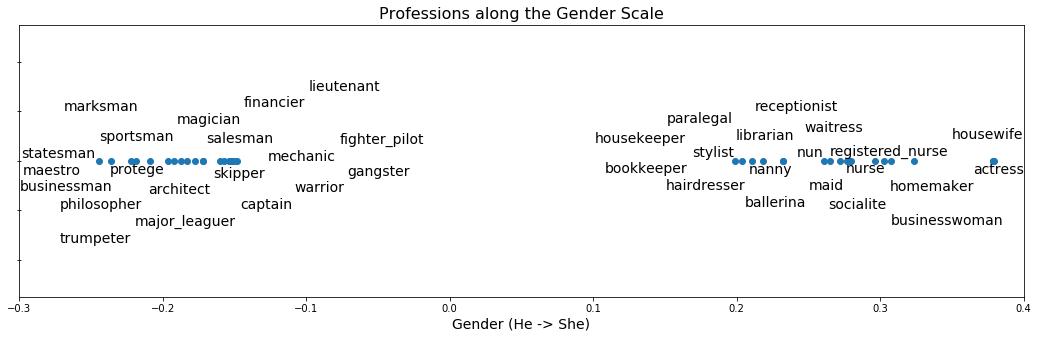

In [10]:
from adjustText import adjust_text

y = np.zeros(len(points))
fig, ax = plt.subplots()
ax.set_title('Professions along the Gender Scale', fontsize=16)
fig.set_size_inches(18, 5)
ax.set_xlim([-.3,.4])
ax.set_xlabel("Gender (He -> She)", fontsize=14)
ax.plot(points, y, 'o')
plt.tick_params(axis='y', which='both', direction='inout', labelleft='off')
plt.rcParams.update({'font.size': 14})

texts = []
for x, y, s in zip(points, y, names):
    texts.append(plt.text(x, y, s))

adjust_text(texts)
plt.show()
plt.savefig("gender_bias_profession.png", dpi=600 )

### Analogies
she is to x as he is to y

In [11]:
a_gender_ = em.best_analogies_dist_thresh(gender_)
a_gender = em.best_analogies_dist_thresh(gender)
basic_a = {a:b for (a,b,c) in a_gender_}
pca_a = {a:b for (a,b,c) in a_gender}

Computing neighbors
Mean: 10.2197328085
Median: 7.0


In [12]:
print("Analogies: she -> he_1 | he_2")
print("word -> she-he analogy | PCA analogy\n")
for w in basic_a.keys():
    try:
        print("{} -> {} | {}".format(w, basic_a[w], pca_a[w]))
    except KeyError:
        pass

Analogies: she -> he_1 | he_2
word -> she-he analogy | PCA analogy

she -> he | he
herself -> himself | himself
her -> his | his
woman -> man | man
daughter -> son | son
businesswoman -> businessman | businessman
girl -> boy | boy
actress -> actor | actor
chairwoman -> chairman | chairman
heroine -> hero | hero
mother -> father | father
spokeswoman -> spokesman | spokesman
sister -> brother | brother
girls -> boys | boys
sisters -> brothers | brothers
queen -> king | king
niece -> nephew | nephew
councilwoman -> councilman | councilman
motherhood -> fatherhood | fatherhood
women -> men | men
petite -> lanky | lanky
ovarian_cancer -> prostate_cancer | prostate_cancer
Anne -> John | John
schoolgirl -> schoolboy | schoolboy
granddaughter -> grandson | grandson
aunt -> uncle | uncle
matriarch -> patriarch | patriarch
twin_sister -> twin_brother | twin_brother
mom -> dad | dad
lesbian -> gay | gay
husband -> younger_brother | younger_brother
gal -> dude | dude
lady -> gentleman | gentleman


Simple Visualization

In [13]:
we.viz(a_gender)

   0                      herself | himself                      0.94
   1                          she | he                           0.94
   2                          her | his                          0.91
   3                        woman | man                          0.82
   4                     daughter | son                          0.74
   5                         girl | boy                          0.74
   6                      actress | actor                        0.72
   7                businesswoman | businessman                  0.70
   8                       sister | brother                      0.69
   9                       mother | father                       0.69
  10                  spokeswoman | spokesman                    0.67
  11                      heroine | hero                         0.67
  12                   chairwoman | chairman                     0.67
  13                      sisters | brothers                     0.67
  14                

### Debiasing
Let's debias the embeddings and measure bias again

In [14]:
import json
# dwe.debias
with open('debiaswe/data/definitional_pairs.json', "r") as f:
    defs = json.load(f)

with open('debiaswe/data/equalize_pairs.json', "r") as f:
    equalize_pairs = json.load(f)
    
with open('debiaswe/data/gender_specific_seed.json', "r") as f:
    gender_specific_words = json.load(f)

print("definitional", defs)
print("\ngender specific", len(gender_specific_words), gender_specific_words[:10])

definitional [['woman', 'man'], ['girl', 'boy'], ['she', 'he'], ['mother', 'father'], ['daughter', 'son'], ['gal', 'guy'], ['female', 'male'], ['her', 'his'], ['herself', 'himself'], ['Mary', 'John']]

gender specific 218 ['actress', 'actresses', 'aunt', 'aunts', 'bachelor', 'ballerina', 'barbershop', 'baritone', 'beard', 'beards']


In [15]:
# import errors, sourced from debiaswe/debiaswe/debias

def debias(embedding, gender_specific_words, definitional, equalize):
    E = embedding
    gender_direction = we.doPCA(definitional, E).components_[0]
    specific_set = set(gender_specific_words)
    for i, w in enumerate(E.words):
        if w not in specific_set:
            E.vecs[i] = we.drop(E.vecs[i], gender_direction)
    E.normalize()
    candidates = {x for e1, e2 in equalize for x in [(e1.lower(), e2.lower()),
                                                     (e1.title(), e2.title()),
                                                     (e1.upper(), e2.upper())]}
    print(candidates)
    for (a, b) in candidates:
        if (a in E.index and b in E.index):
            y = we.drop((E.v(a) + E.v(b)) / 2, gender_direction)
            z = np.sqrt(1 - np.linalg.norm(y)**2)
            if (E.v(a) - E.v(b)).dot(gender_direction) < 0:
                z = -z
            E.vecs[E.index[a]] = z * gender_direction + y
            E.vecs[E.index[b]] = -z * gender_direction + y
    E.normalize()
    return E

In [16]:
em_d = debias(em, gender_specific_words, defs, equalize_pairs)

26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine
{('MAN', 'WOMAN'), ('Prostate_Cancer', 'Ovarian_Cancer'), ('wives', 'husbands'), ('Gentlemen', 'Ladies'), ('GELDING', 'MARE'), ('councilman', 'councilwoman'), ('TWIN_BROTHER', 'TWIN_SISTER'), ('gelding', 'mare'), ('Grandsons', 'Granddaughters'), ('gentlemen', 'ladies'), ('Son', 'Daughter'), ('HIMSELF', 'HERSELF'), ('kings', 'queens'), ('Catholic_Priest', 'Nun'), ('twin_brother', 'twin_sister'), ('CATHOLIC_PRIEST', 'NUN'), ('MEN', 'WOMEN'), ('Congressman', 'Congresswoman'), ('Fraternity', 'Sorority'), ('Grandpa', 'Grandma'), ('GRANDFATHER', 'GRANDMOTHER'), ('Himself', 'Herself'), ('SON', 'DAUGHTER'), ('FATHER', 'MOTHER'), ('ex_girlfriend', 'ex_boyfriend'), ('king', 'queen'), ('brother', 'sister'), ('COLT', 'FILLY'), ('Councilman', 'Councilwoman'), ('Man', 'Woman'), ('HIS', 'HER'), ('FELLA', 'GRANNY'), ('Monastery', 'Convent'), ('Fella', 'Granny'), ('KINGS', 'QUEENS'), ('KING', 'QUEEN'), ('Dudes', 'Gals'), 

In [17]:
debiased_profs_ = sorted([(em_d.v(w).dot(gender_), w) for w in profession_words])
debiased_profs = sorted([(em_d.v(w).dot(gender), w) for w in profession_words])

names = []
points = []
print("Top male: ")
for i in range(0,20):
    points.append(debiased_profs_[i][0])
    names.append(debiased_profs_[i][1])
    print("she-he: {} | 10-pair: {}".format(debiased_profs_[i], debiased_profs[i]))
print("\nTop female: ")
for i in reversed(range(1, 20)):
    points.append(debiased_profs_[-i][0])
    names.append(debiased_profs_[-i][1])
    print("she-he: {} | 10-pair: {}".format(debiased_profs_[-i], debiased_profs[-i]))

Top male: 
she-he: (-0.41963249, 'congressman') | 10-pair: (-0.43325216, 'businessman')
she-he: (-0.40675855, 'businessman') | 10-pair: (-0.42799938, 'congressman')
she-he: (-0.32398781, 'councilman') | 10-pair: (-0.36525279, 'dad')
she-he: (-0.3096709, 'dad') | 10-pair: (-0.35791725, 'councilman')
she-he: (-0.21665451, 'statesman') | 10-pair: (-0.22225758, 'statesman')
she-he: (-0.11345412, 'salesman') | 10-pair: (-0.15711334, 'salesman')
she-he: (-0.073004864, 'monk') | 10-pair: (-0.10675359, 'handyman')
she-he: (-0.072163954, 'handyman') | 10-pair: (-0.081720017, 'monk')
she-he: (-0.049468201, 'minister') | 10-pair: (-1.4714897e-07, 'promoter')
she-he: (-0.043583825, 'archbishop') | 10-pair: (-1.3783574e-07, 'crooner')
she-he: (-0.040207177, 'bishop') | 10-pair: (-9.3597919e-08, 'alter_ego')
she-he: (-0.03833244, 'commissioner') | 10-pair: (-9.033829e-08, 'skipper')
she-he: (-0.035724342, 'surgeon') | 10-pair: (-8.1956387e-08, 'baron')
she-he: (-0.033134002, 'trader') | 10-pair: (-7

Let's visualize debiased professions.

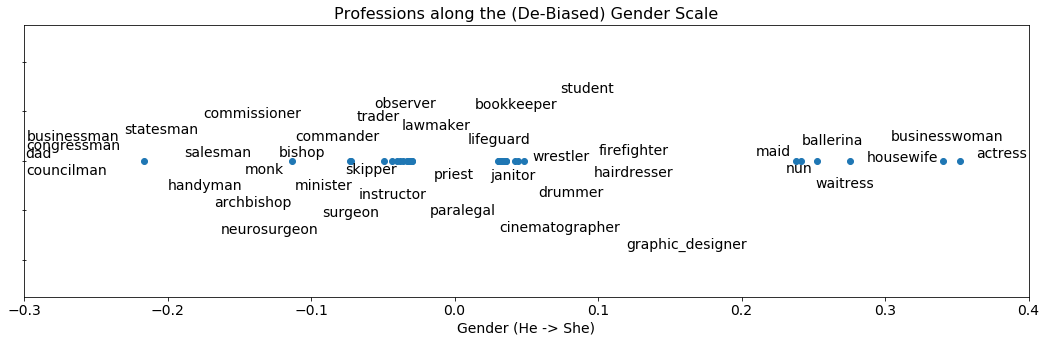

In [18]:
from adjustText import adjust_text

y = np.zeros(len(points))
fig, ax = plt.subplots()
ax.set_title('Professions along the (De-Biased) Gender Scale', fontsize=16)
fig.set_size_inches(18, 5)
ax.set_xlim([-.3,.4])
ax.set_xlabel("Gender (He -> She)", fontsize=14)
ax.plot(points, y, 'o')
plt.tick_params(axis='y', which='both', direction='inout', labelleft='off')
plt.rcParams.update({'font.size': 14})

texts = []
for x, y, s in zip(points, y, names):
    texts.append(plt.text(x, y, s))

adjust_text(texts)
plt.show()
plt.savefig("gender_debias_profession.png", dpi=600)

In [19]:
debiased_a_ = em_d.best_analogies_dist_thresh(gender_)
debiased_a = em_d.best_analogies_dist_thresh(gender)
basic_a_d = {a:b for (a,b,c) in debiased_a_}
pca_a_d = {a:b for (a,b,c) in debiased_a}

print("Analogies: she -> he_1 | he_2")
print("word -> she-he analogy | PCA analogy\n")
for w in basic_a.keys():
    try:
        print("{} -> {} | {}".format(w, basic_a_d[w], pca_a_d[w]))
    except KeyError:
        pass

Computing neighbors
Mean: 10.2185974341
Median: 7.0
Analogies: she -> he_1 | he_2
word -> she-he analogy | PCA analogy

she -> he | he
herself -> himself | himself
her -> his | his
woman -> man | man
daughter -> son | son
businesswoman -> businessman | businessman
girl -> boy | boy
actress -> actor | actor
chairwoman -> chairman | chairman
heroine -> protagonist | protagonist
mother -> father | father
spokeswoman -> spokesman | spokesman
sister -> brother | brother
girls -> boys | boys
sisters -> brothers | brothers
queen -> king | king
niece -> nephew | nephew
councilwoman -> councilman | councilman
motherhood -> fatherhood | fatherhood
women -> men | men
ovarian_cancer -> prostate_cancer | prostate_cancer
schoolgirl -> schoolboy | schoolboy
granddaughter -> grandson | grandson
aunt -> uncle | uncle
matriarch -> patriarch | patriarch
twin_sister -> twin_brother | twin_brother
mom -> dad | dad
lesbian -> gay | gay
husband -> younger_brother | younger_brother
gal -> dude | dude
lady -> 

Another simple visualization

In [20]:
we.viz(debiased_a)

   0                        niece | nephew                       1.0
   1                         mare | gelding                      1.0
   2                         moms | dads                         1.0
   3                granddaughter | grandson                     1.0
   4                 councilwoman | councilman                   1.0
   5               granddaughters | grandsons                    1.0
   6                         gals | dudes                        1.0
   7                   motherhood | fatherhood                   1.0
   8                      mothers | fathers                      1.0
   9                          her | his                          1.0
  10                      herself | himself                      1.0
  11                        girls | boys                         1.0
  12                    daughters | sons                         1.0
  13                      convent | monastery                    1.0
  14                 ex_boyfriend 